In [ ]:
# import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

# from rich import print
import time 
# 全局取消证书验证
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
def timeSince(since: float) -> str:
    s = time.time() - since
    return f"{int(s/60):2}m {int(s%60):02}s"

## 加载并归一化数据集

In [4]:
myTransforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

batch_size = 128

trainset = CIFAR10(root='./cifar-10-python', train=True, download=True, transform=myTransforms)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)

testset = CIFAR10(root='./cifar-10-python', train=False, download=True, transform=myTransforms)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=0)


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /home/ma-user/data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.9)
               ToTensor()
               Normalize(mean=[0.4915 0.4823 0.4468], std=[0.247  0.2435 0.2616])
           )


# 定义网络，直接调用我自己的就ok

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [7]:
# 定义自己的网络
from coatnet import coatnet_0
from coatnet import coatnet_1
from coatnet import coatnet_2
from coatnet import coatnet_3
from coatnet import coatnet_4
from coatnet import coatnet_5

model = coatnet_3()
print(model(torch.randn(1,3,32,32,)).shape)

torch.Size([1, 10])


## 模型参数统计

In [8]:
from torchsummary import summary
summary(model.to(device), input_size=(3, 32, 32), batch_size=batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [1024, 192, 16, 16]           5,184
       BatchNorm2d-2        [1024, 192, 16, 16]             384
              GELU-3        [1024, 192, 16, 16]               0
            Conv2d-4        [1024, 192, 16, 16]         331,776
       BatchNorm2d-5        [1024, 192, 16, 16]             384
              GELU-6        [1024, 192, 16, 16]               0
         MaxPool2d-7          [1024, 192, 8, 8]               0
            Conv2d-8          [1024, 192, 8, 8]          36,864
       BatchNorm2d-9        [1024, 192, 16, 16]             384
           Conv2d-10          [1024, 768, 8, 8]         147,456
      BatchNorm2d-11          [1024, 768, 8, 8]           1,536
             GELU-12          [1024, 768, 8, 8]               0
           Conv2d-13          [1024, 768, 8, 8]           6,912
      BatchNorm2d-14          [1024, 76

## 训练网络

In [9]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from datetime import datetime


def fwd_pass(net, loader, loss_function, optimizer, train=False):
    if train: net.train()
    else:     net.eval()

    total_loss = 0
    y_pred, y = [], []
    for X, labels in loader: #加载
        X, labels = X.to(device), labels.to(device)
        # ===================前向传播=====================
        outputs = model(X)
        loss = loss_function(outputs, labels) 
        total_loss += loss.item()
        # ===================反向传播====================
        if train:
            optimizer.zero_grad()# 归零
            loss.backward()
            optimizer.step()
        # ===============预测===============
        with torch.no_grad():
            y_hat = outputs.argmax(dim=1)
            y_pred.extend(y_hat.cpu().numpy().tolist())
            y.extend(labels.cpu().numpy().tolist())

    # =================返回=====================
    with torch.no_grad():
        total_loss /= len(loader.dataset)
        acc = accuracy_score(y, y_pred)*100
        f1 = f1_score(y, y_pred, average="weighted")*100

    return total_loss, acc, f1


logs = dict( trainlosses=list(), testlosses=list(), 
            trainaccs=list(), testaccs=list() )
    
    
#TRAINING THE NETWORK
def train(model, train_loader, test_loader,
          optimizer, loss_function, epoch_num=1, device=device):
    model.to(device)
    torch.manual_seed(14)
    
    start = time.time()
    print(f"Training Process Starts at {datetime.now().strftime('%H:%M:%S')} ... ")
    
    epoch = 1

    # loop over the dataset multiple times
    while epoch<=epoch_num:
        # Training
        train_loss, train_acc, train_f1 = fwd_pass(model, train_loader, loss_function, 
                                                       optimizer, train=True)
            
        # Testing
        with torch.no_grad():
            test_loss, test_acc, test_f1 = fwd_pass(model, test_loader, loss_function, 
                                                    optimizer, train=False)
        
        
        reset='\n' if epoch <= 5 or epoch%5==0 else '\r'
        print(f"Epoch[{epoch:2d}]>>>",
            f"Train/Test loss: {train_loss:.7f}/{test_loss:.7f},",
            f"Acc.: {train_acc:.2f}/{test_acc:.2f}",
            f"[[{timeSince(start)}]]", end=reset)
            
        # ===================log========================
        logs['trainlosses'].append(train_loss)
        logs['trainaccs'].append(train_acc)
        logs['testlosses'].append(test_loss)
        logs['testaccs'].append(test_acc)
                
        epoch += 1

    print(f'测试集F1: {test_f1}')
    print(f'Finished in {timeSince(start)}')
    return logs

In [10]:
model = coatnet_3()

criterion = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = optim.Adam( model.parameters(), lr=learning_rate, weight_decay=1e-5,)

logs = train(model, train_loader=trainloader, test_loader=testloader,
             optimizer=optimizer, loss_function=criterion, 
             epoch_num=60)

Training Process Starts at 13:32:45 ... 
Epoch[ 1]>>> Train/Test loss: 0.0190010/0.0047902, Acc.: 15.29/19.49 [[ 0m 25s]]
Epoch[ 2]>>> Train/Test loss: 0.0020776/0.0016095, Acc.: 31.46/41.30 [[ 0m 51s]]
Epoch[ 3]>>> Train/Test loss: 0.0014769/0.0013909, Acc.: 44.35/49.05 [[ 1m 17s]]
Epoch[ 4]>>> Train/Test loss: 0.0012931/0.0012708, Acc.: 51.73/53.27 [[ 1m 43s]]
Epoch[ 5]>>> Train/Test loss: 0.0011182/0.0011487, Acc.: 58.75/58.54 [[ 2m 08s]]
Epoch[10]>>> Train/Test loss: 0.0003639/0.0011040, Acc.: 87.27/68.62 [[ 4m 17s]]
Epoch[15]>>> Train/Test loss: 0.0001497/0.0010627, Acc.: 95.14/73.40 [[ 6m 26s]]
Epoch[20]>>> Train/Test loss: 0.0000992/0.0010881, Acc.: 96.93/74.10 [[ 8m 35s]]
Epoch[25]>>> Train/Test loss: 0.0000733/0.0010397, Acc.: 97.65/76.37 [ 51s]]
Epoch[30]>>> Train/Test loss: 0.0000613/0.0010711, Acc.: 98.13/76.54 [ 06s]]
Epoch[35]>>> Train/Test loss: 0.0000595/0.0010494, Acc.: 98.09/77.26 [ 15s]]
Epoch[40]>>> Train/Test loss: 0.0000546/0.0010395, Acc.: 98.26/77.14 [ 36s]]
Epo

In [11]:
model_name = f'cifar10.h5'
torch.save(model, model_name)

#用保存了的模型继续跑
model = torch.load('./cifar10.h5')
learning_rate = 1e-4
logs = train(model, train_loader=trainloader, test_loader=testloader,
             optimizer=optimizer, loss_function=criterion, 
             epoch_num=30)

Training Process Starts at 14:01:55 ... 
Epoch[ 1]>>> Train/Test loss: 0.0000271/0.0010124, Acc.: 99.14/79.54 [[ 0m 38s]]
Epoch[ 2]>>> Train/Test loss: 0.0000270/0.0010116, Acc.: 99.09/79.54 [[ 1m 18s]]
Epoch[ 3]>>> Train/Test loss: 0.0000261/0.0010126, Acc.: 99.15/79.52 [[ 1m 56s]]
Epoch[ 4]>>> Train/Test loss: 0.0000284/0.0010129, Acc.: 99.07/79.41 [[ 2m 35s]]
Epoch[ 5]>>> Train/Test loss: 0.0000276/0.0010119, Acc.: 99.07/79.52 [[ 3m 14s]]
Epoch[10]>>> Train/Test loss: 0.0000261/0.0010131, Acc.: 99.13/79.46 [[ 6m 28s]]
Epoch[15]>>> Train/Test loss: 0.0000284/0.0010120, Acc.: 99.06/79.51 [[ 9m 36s]]
Epoch[20]>>> Train/Test loss: 0.0000263/0.0010135, Acc.: 99.15/79.45 [ 51s]]
Epoch[25]>>> Train/Test loss: 0.0000269/0.0010125, Acc.: 99.09/79.40 [ 57s]]
Epoch[30]>>> Train/Test loss: 0.0000250/0.0010124, Acc.: 99.18/79.50 [ 56s]]
测试集F1: 79.54241748422825
Finished in 18m 56s


In [12]:
model_name = f'cifar10.h5'
torch.save(model, model_name)

#用保存了的模型继续跑
model = torch.load('./cifar10.h5')
learning_rate = 1e-5
logs = train(model, train_loader=trainloader, test_loader=testloader,
             optimizer=optimizer, loss_function=criterion, 
             epoch_num=10)

Training Process Starts at 14:20:53 ... 
Epoch[ 1]>>> Train/Test loss: 0.0000271/0.0010123, Acc.: 99.14/79.55 [[ 0m 26s]]
Epoch[ 2]>>> Train/Test loss: 0.0000270/0.0010116, Acc.: 99.09/79.54 [[ 0m 58s]]
Epoch[ 3]>>> Train/Test loss: 0.0000261/0.0010126, Acc.: 99.15/79.52 [[ 1m 37s]]
Epoch[ 4]>>> Train/Test loss: 0.0000284/0.0010129, Acc.: 99.07/79.41 [[ 2m 11s]]
Epoch[ 5]>>> Train/Test loss: 0.0000276/0.0010119, Acc.: 99.07/79.52 [[ 2m 40s]]
Epoch[10]>>> Train/Test loss: 0.0000261/0.0010131, Acc.: 99.13/79.46 [[ 4m 53s]]
测试集F1: 79.4997832955029
Finished in  4m 53s


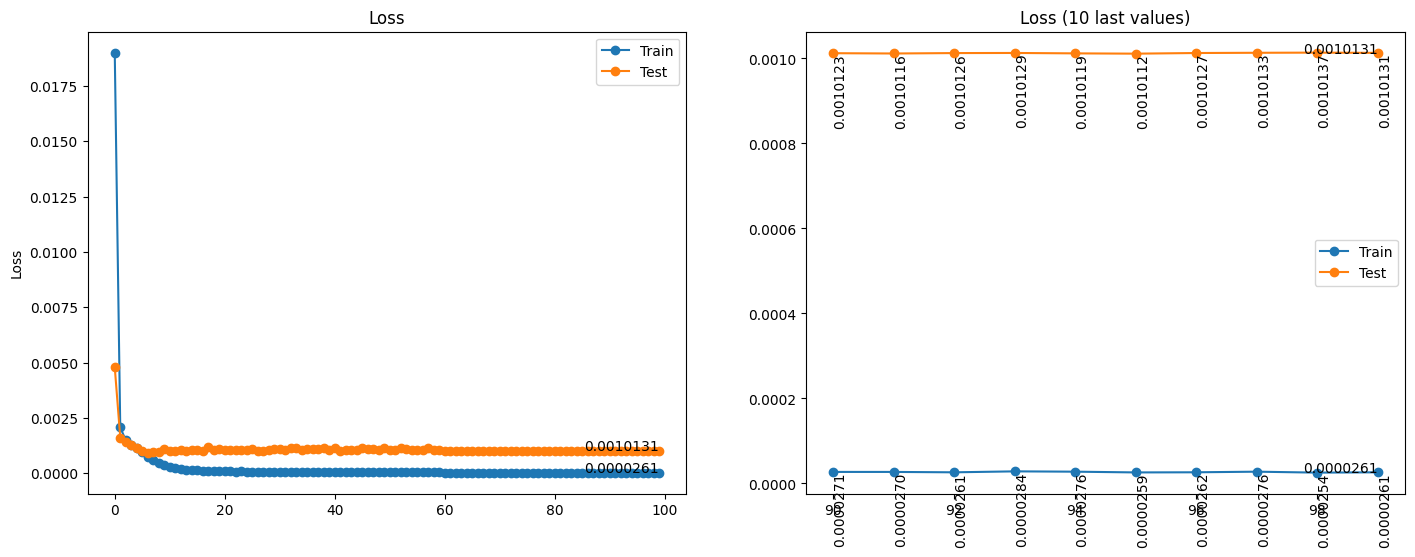

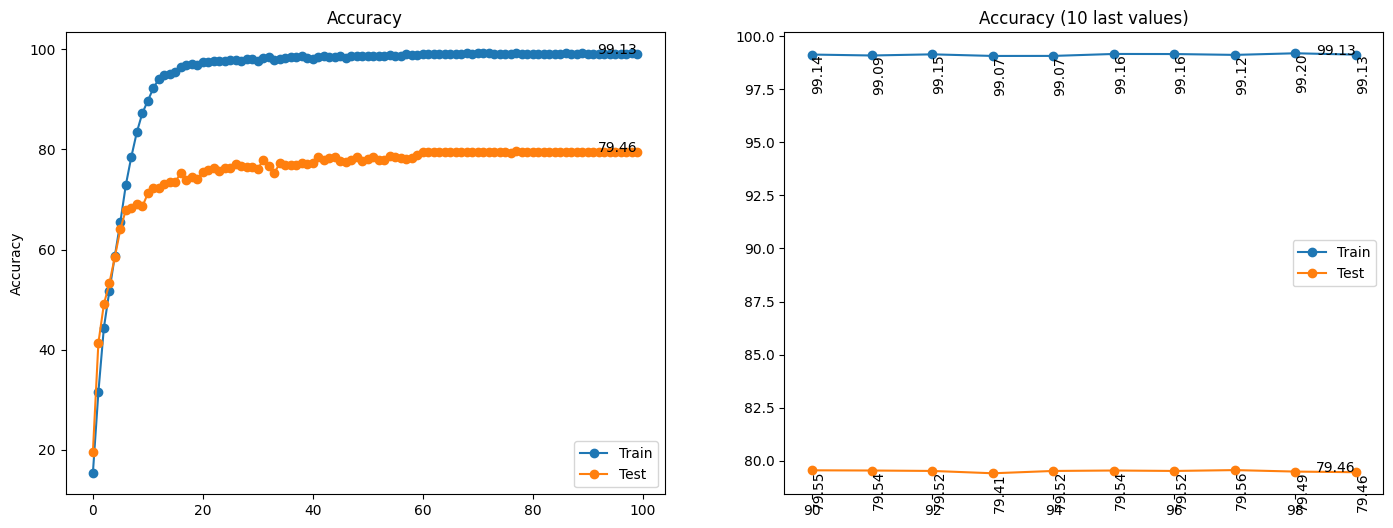

In [13]:
def res_plot(plotdata, xlabel='epoch', legend=['Train','Test'], title='Loss'):
    fig, axes = plt.subplots(1,2, figsize = (17,6))
    axes[0].set_ylabel(title)
    epochs = len(plotdata[0])-1
    for index, ax in enumerate(axes):
        n = 10 if index==1 else 0
        x = range(epochs-n+1, epochs+1) if index==1 else range(epochs+1)
        title = f"{title} ({n} last values)" if index==1 else title
#         ax.set_xlabel(xlabel)
        ax.set_title(title)
        ax.plot(x, plotdata[0][-n:], '-o', label=legend[0])
        ax.plot(x, plotdata[1][-n:], '-o', label=legend[1])
        p = 7 if 'loss'in title.lower() else 2
        if index==1:
            for i,j in list(zip(x,plotdata[1][-n:]))+list(zip(x, plotdata[0][-n:])):
                ax.annotate(f"{j:.{p}f}", xy=(i,j), rotation=90, va='top')
        ax.annotate(f"{plotdata[0][-1]:.{p}f}", xy=(len(plotdata[0])-1,plotdata[0][-1]),
                   ha="right")
        ax.annotate(f"{plotdata[1][-1]:.{p}f}", xy=(len(plotdata[1])-1,plotdata[1][-1]),
                   ha="right")
        ax.legend()

    plt.show()
    
res_plot((logs['trainlosses'], logs['testlosses']), title='Loss')
res_plot((logs['trainaccs'], logs['testaccs']), title='Accuracy' )

## 每个类的精度

In [14]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

class_correct = [0.] * 10
class_total = [0.] * 10 
y_test, y_pred = [] , []
X_test = []

with torch.no_grad():
    for images, labels in testloader:
        X_test.extend([_ for _ in images])
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs, 1)
        predicted = predicted.cpu()
        c = (predicted == labels).squeeze()
        for i, label in enumerate(labels):
            class_correct[label] += c[i].item()
            class_total[label] += 1
        y_pred.extend(predicted.numpy())
        y_test.extend(labels.cpu().numpy())

for i in range(10):
    print(f"Acuracy of {classes[i]:5s}: {100*class_correct[i]/class_total[i]:2.0f}%")

Acuracy of plane: 82%
Acuracy of car  : 90%
Acuracy of bird : 75%
Acuracy of cat  : 64%
Acuracy of deer : 83%
Acuracy of dog  : 65%
Acuracy of frog : 82%
Acuracy of horse: 81%
Acuracy of ship : 88%
Acuracy of truck: 85%


In [15]:
from sklearn.metrics import confusion_matrix, classification_report

ac = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred, target_names=classes)
print("Accuracy is :",ac) 
print(cr)

Accuracy is : 0.7946
              precision    recall  f1-score   support

       plane       0.84      0.82      0.83      1000
         car       0.89      0.90      0.90      1000
        bird       0.71      0.75      0.73      1000
         cat       0.60      0.64      0.62      1000
        deer       0.73      0.83      0.77      1000
         dog       0.76      0.65      0.70      1000
        frog       0.83      0.82      0.82      1000
       horse       0.86      0.81      0.83      1000
        ship       0.88      0.88      0.88      1000
       truck       0.88      0.85      0.86      1000

    accuracy                           0.79     10000
   macro avg       0.80      0.79      0.79     10000
weighted avg       0.80      0.79      0.79     10000



### 混淆矩阵

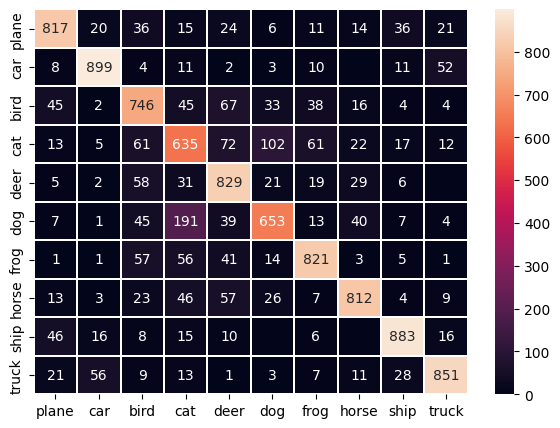

In [16]:
# 混淆矩阵

import seaborn as sns, pandas as pd

labels = pd.DataFrame(cm).applymap(lambda v: f"{v}" if v!=0 else f"")
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=labels, fmt='s', xticklabels=classes, yticklabels=classes, linewidths=0.1 )
plt.show()

## 保存模型的参数

In [ ]:
model_name = f'cifar10[1-82%].h5'
torch.save(model, model_name)
!cp {model_name} cifar10.h5
#!ls -sh cifar10.h5